In [77]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import save_image
sns.set_theme()
torch.set_default_dtype(torch.float32)

In [78]:
class Encoder(nn.Module):
    def __init__(self,sizes):
        super().__init__()
        self.latent_size=sizes[-1]
        self.network=[]
        for i in range(len(sizes)-2):
            self.network.append(nn.Linear(sizes[i],sizes[i+1]))
            self.network.append(nn.ReLU())
        self.encode_mu=nn.Linear(sizes[-2],sizes[-1])
        self.encode_sigma=nn.Linear(sizes[-2],sizes[-1])
        self.network=nn.Sequential(*self.network)

    def forward(self,x):
        x=self.network(x)
        mu=self.encode_mu(x)
        sigma=torch.exp(self.encode_sigma(x))
        return mu,sigma



class Decoder(nn.Module):
    def __init__(self,sizes):
        super().__init__()
        self.network=[]
        for i in range(len(sizes)-2):
            self.network.append(nn.Linear(sizes[i],sizes[i+1]))
            self.network.append(nn.ReLU())
        self.network.append(nn.Linear(sizes[-2],sizes[-1]))
        self.network=nn.Sequential(*self.network)

    def forward(self,x):
        return torch.sigmoid(self.network(x))

class VAE_torch(nn.Module):
    def __init__(self,encoder, decoder,latent_size):
        super().__init__()
        self.latent_size=latent_size
        self.encoder=encoder
        self.decoder=decoder
    
    def forward(self,x):
        mu,sigma=self.encoder(x)
        eps=torch.normal(0,1,(mu.shape[0],self.latent_size))
        sampled_vector=mu+eps*sigma
        return self.decoder(sampled_vector),mu,sigma

    def sample(self,x,epsilon=0.0):
        mu,sigma=self.encoder(x)
        sampled_vector=torch.zeros(x.shape[0],self.latent_size)
        for j in range(mu.shape[0]):
            sampled_vector[j,:]=torch.distributions.Normal(mu[j],sigma[j]).sample()
        print(sampled_vector)
        return self.decoder(sampled_vector)


def KL(mean,sigma):
    return 0.5*torch.sum((torch.sum(sigma.pow(2),dim=1)+torch.sum(mean.pow(2),dim=1)-torch.sum(torch.log(sigma.pow(2)),dim=1)-1))

def ELBO(values,pred_values,mean,sigma,beta=1):
    return (nn.functional.binary_cross_entropy(pred_values, values,reduction="sum")+beta*KL(mean,sigma))/values.shape[0]

def ELBO_MSE(values,pred_values,mean,sigma,beta=1):
    return (nn.functional.mse_loss(pred_values,values,reduction="sum")+beta*KL(mean,sigma))/values.shape[0]

def visualize(res1,VAE):
    new=VAE.sample(res1.expand(5,784))
    f,axes=plt.subplots(2,3,figsize=(21,14))
    ax=axes.flatten()[0]
    ax.imshow(res1.reshape(28,28),cmap="viridis_r")
    ax.set_title("Original image")
    for spine in ax.spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(4)
    for j in range(5):
        ax=axes.flatten()[j+1]
        ax.imshow(new[j,:].detach().numpy().reshape(28,28),cmap="viridis_r")
    plt.tight_layout()


def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']
        
    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.
    
    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (torch.tensor(x_train,dtype=torch.float32), torch.tensor(y_train,dtype=torch.float32)), (torch.tensor(x_test,dtype=torch.float32),torch.tensor(y_test,dtype=torch.float32))

def generate(VAE,n,name="images.png"):
    input=torch.normal(0,1,[n*n,VAE.latent_size])
    output=VAE.decoder(input)
    save_image(output.reshape(n*n,1,28,28),name)

In [79]:
(xtrain,ytrain),(xtest,ytest)=load_mnist()

In [80]:
num_epoch=40
batch=100
VAE=VAE_torch(Encoder([784,110,30,10]),Decoder([10,30,110,784]),10)
optim=torch.optim.Adam(VAE.parameters(),lr=0.003)
beta=1
err_train=[]
err_test=[]
for i in range(num_epoch):
    for j in range(0,60000,batch):
        xbatch=xtrain[j:j+batch]
        optim.zero_grad()
        results,mean,sigma=VAE(xbatch)
        loss=ELBO(xbatch,results,mean,sigma,beta=beta)
        loss.backward()
        optim.step()
    with torch.no_grad():
        test_res,mean,sigma=VAE(xtest)
        loss_test=ELBO(xtest,test_res,mean,sigma,beta=beta)
        print("Epoche: ",i,"loss train: {:.3f}".format(loss.item()),"loss test: {:.3f}".format(loss_test.item()))
        err_train.append(loss.item())
        err_test.append(loss_test.item())

Epoche:  0 loss train: 165.403 loss test: 158.678
Epoche:  1 loss train: 141.308 loss test: 138.807
Epoche:  2 loss train: 134.346 loss test: 133.323
Epoche:  3 loss train: 133.378 loss test: 132.156
Epoche:  4 loss train: 129.953 loss test: 130.821
Epoche:  5 loss train: 129.229 loss test: 128.265
Epoche:  6 loss train: 127.673 loss test: 127.645
Epoche:  7 loss train: 126.877 loss test: 126.719
Epoche:  8 loss train: 127.044 loss test: 125.813
Epoche:  9 loss train: 125.768 loss test: 125.196
Epoche:  10 loss train: 127.300 loss test: 125.146
Epoche:  11 loss train: 125.479 loss test: 125.209
Epoche:  12 loss train: 125.901 loss test: 125.448
Epoche:  13 loss train: 124.645 loss test: 125.244
Epoche:  14 loss train: 126.289 loss test: 124.287
Epoche:  15 loss train: 123.979 loss test: 124.261
Epoche:  16 loss train: 123.803 loss test: 124.890
Epoche:  17 loss train: 123.580 loss test: 124.138
Epoche:  18 loss train: 123.523 loss test: 124.924
Epoche:  19 loss train: 124.147 loss test

Text(0.5, 0, 'epoche number')

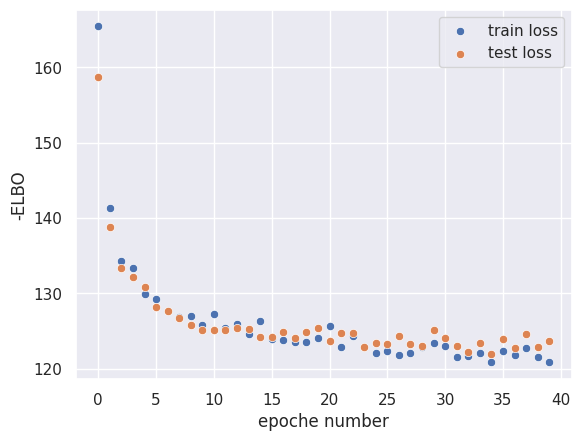

In [81]:
sns.scatterplot(x=np.arange(0,len(err_train)),y=err_train,label="train loss")
sns.scatterplot(x=np.arange(0,len(err_test)),y=err_test,label="test loss")
plt.ylabel(r"-ELBO")
plt.xlabel("epoche number")

tensor([[-1.4318,  0.8274,  0.7261,  0.3073,  0.3985, -0.6503, -0.6802,  2.4575,
         -0.6017,  0.8643],
        [-1.4904,  0.8856,  0.8676, -0.5124,  0.5305, -0.8076, -0.5715, -1.0430,
         -0.4334,  1.8140],
        [-1.6184,  0.8133,  0.5734,  2.5019,  0.5308, -0.8955, -0.5846,  0.5520,
         -0.7934, -1.1519],
        [-1.3891,  0.7360,  1.1199, -0.8761,  0.5057, -0.9113, -0.7530,  0.3845,
         -0.5213,  0.9258],
        [-1.5135,  0.7811,  0.8995,  1.2422,  0.5124, -0.7581, -0.4681, -0.4064,
         -0.6637, -0.3731]])


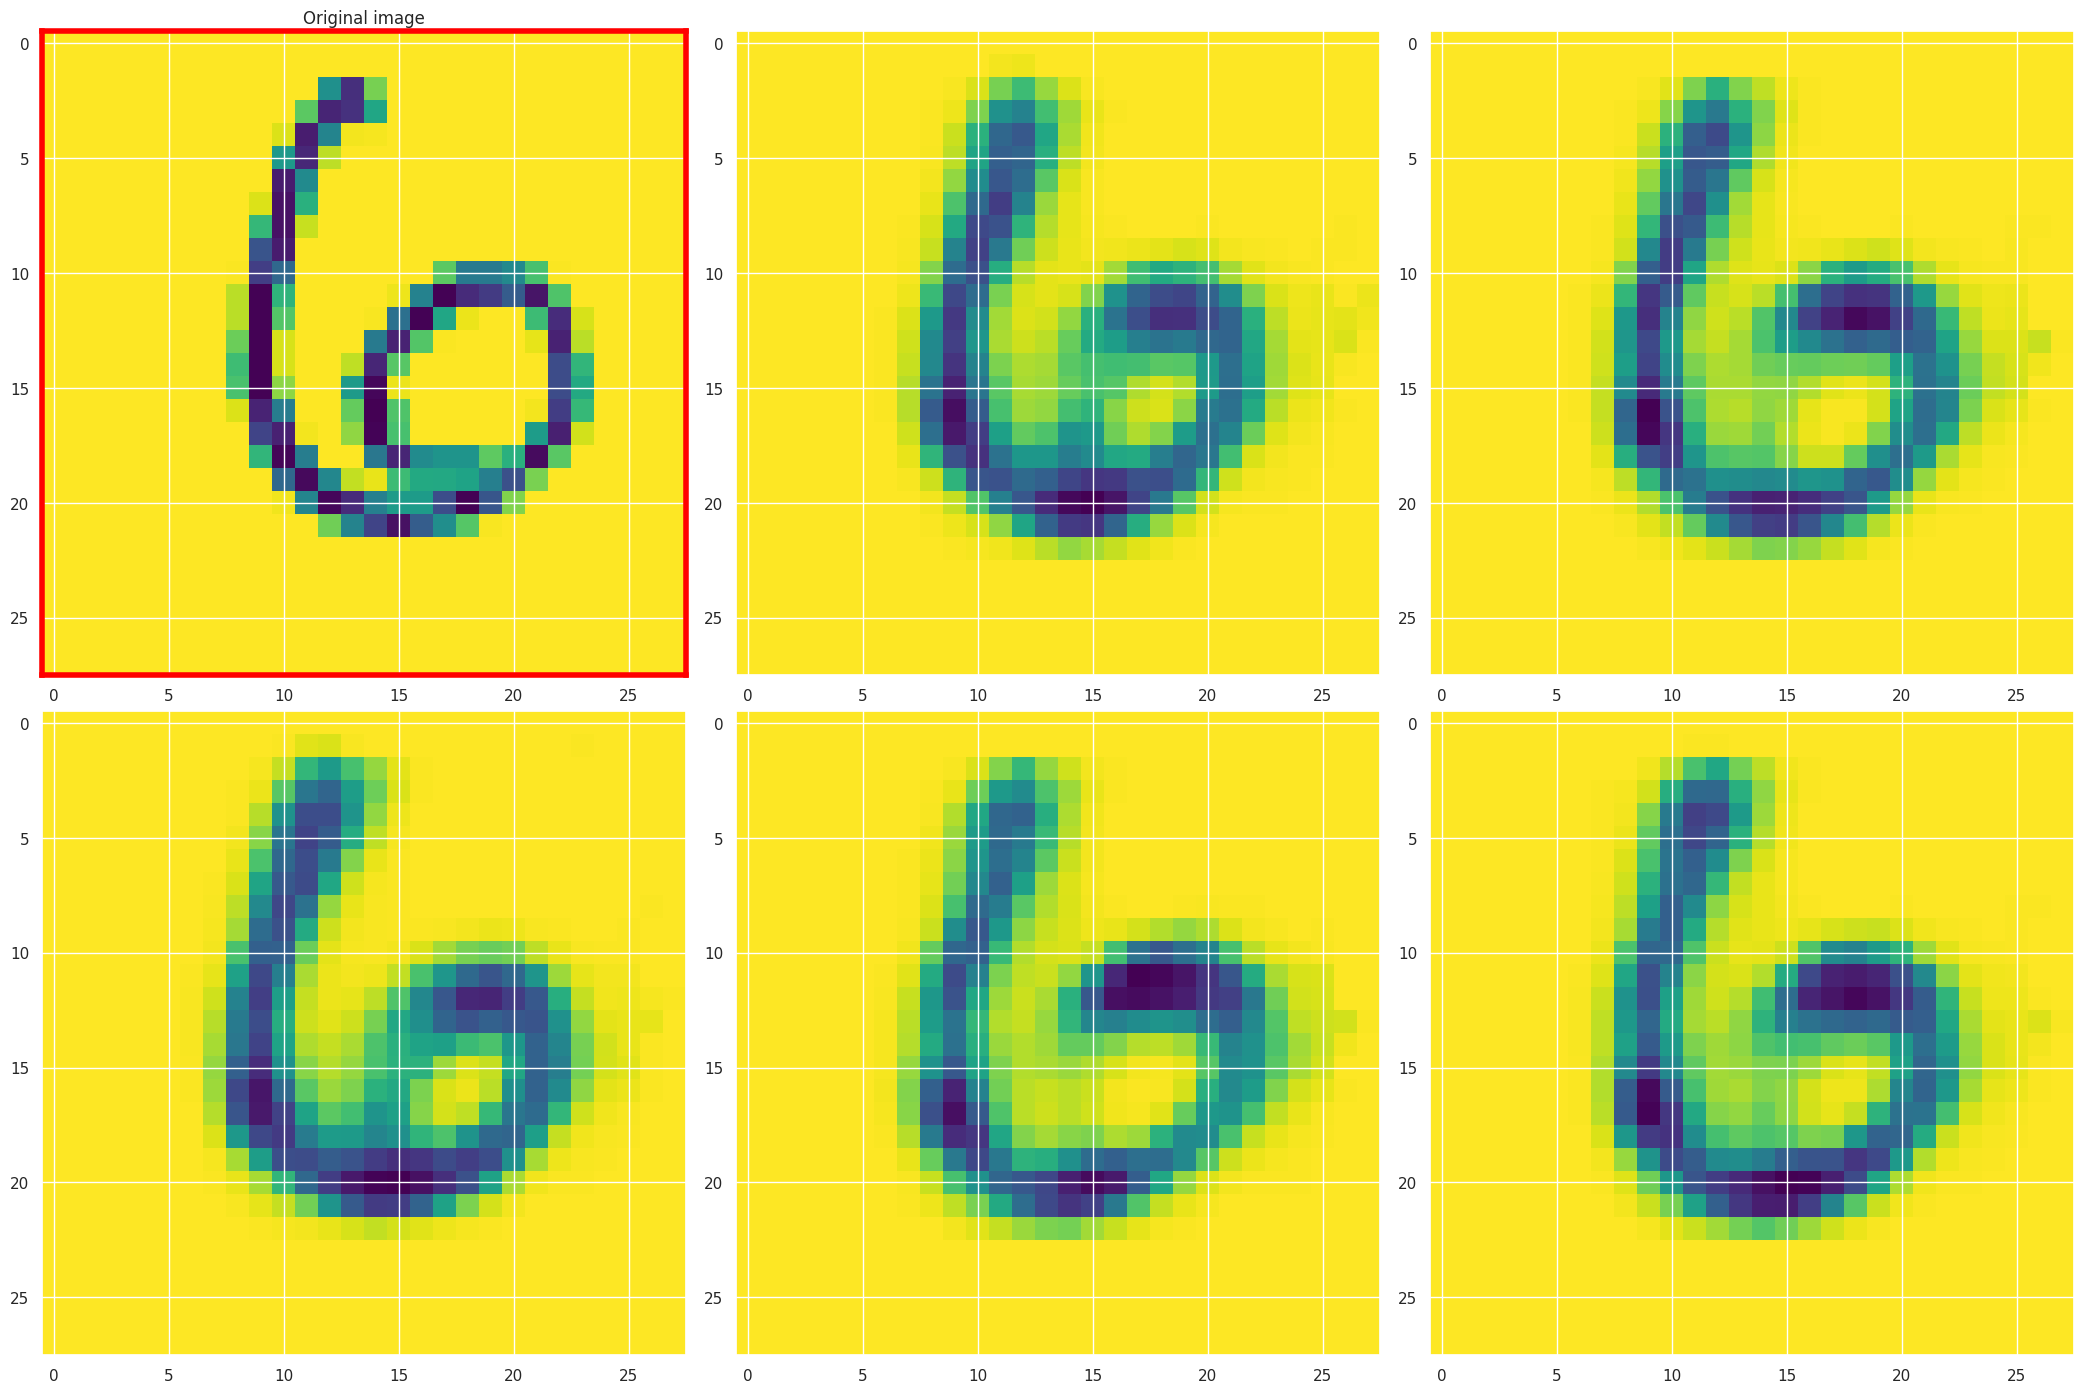

In [82]:
n=100
visualize(xtest[n],VAE)

In [83]:
num_epoch=40    
batch=100
VAE_MSE=VAE_torch(Encoder([784,110,30,10]),Decoder([10,30,110,784]),10)
optim=torch.optim.Adam(VAE_MSE.parameters(),lr=0.003)
beta=1
err_train=[]
err_test=[]
for i in range(num_epoch):
    for j in range(0,60000,batch):
        xbatch=xtrain[j:j+batch]
        optim.zero_grad()
        results,mean,sigma=VAE_MSE(xbatch)
        loss=ELBO_MSE(xbatch,results,mean,sigma,beta=beta)
        loss.backward()
        optim.step()
    with torch.no_grad():
        test_res,mean,sigma=VAE_MSE(xtest)
        loss_test=ELBO_MSE(xtest,test_res,mean,sigma,beta=beta)
        print("Epoche: ",i,"loss train: {:.3f}".format(loss.item()),"loss test: {:.3f}".format(loss_test.item()))
        err_train.append(loss.item())
        err_test.append(loss_test.item())

Epoche:  0 loss train: 49.763 loss test: 47.669
Epoche:  1 loss train: 41.577 loss test: 42.194
Epoche:  2 loss train: 39.630 loss test: 40.319
Epoche:  3 loss train: 38.178 loss test: 39.174
Epoche:  4 loss train: 37.521 loss test: 38.485
Epoche:  5 loss train: 37.103 loss test: 37.998
Epoche:  6 loss train: 37.017 loss test: 37.776
Epoche:  7 loss train: 36.408 loss test: 37.595
Epoche:  8 loss train: 36.258 loss test: 37.696
Epoche:  9 loss train: 36.231 loss test: 38.166
Epoche:  10 loss train: 36.081 loss test: 37.066
Epoche:  11 loss train: 35.361 loss test: 37.314
Epoche:  12 loss train: 36.012 loss test: 37.306
Epoche:  13 loss train: 35.841 loss test: 36.743
Epoche:  14 loss train: 36.042 loss test: 36.767
Epoche:  15 loss train: 35.760 loss test: 36.710
Epoche:  16 loss train: 35.833 loss test: 36.681
Epoche:  17 loss train: 35.858 loss test: 36.874
Epoche:  18 loss train: 35.542 loss test: 36.667
Epoche:  19 loss train: 35.271 loss test: 36.503
Epoche:  20 loss train: 35.782

Text(0.5, 0, 'epoche number')

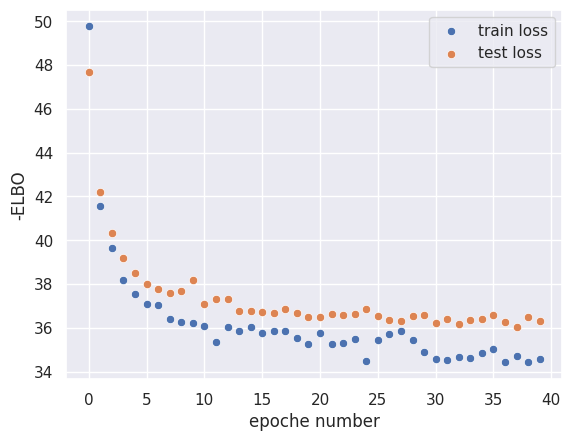

In [84]:
sns.scatterplot(x=np.arange(0,len(err_train)),y=err_train,label="train loss")
sns.scatterplot(x=np.arange(0,len(err_test)),y=err_test,label="test loss")
plt.ylabel(r"-ELBO")
plt.xlabel("epoche number")

tensor([[-0.1720,  1.4503, -0.7039,  0.7094, -0.2037,  0.7572, -0.5501, -0.7383,
          1.0567, -0.9121],
        [ 0.1478,  0.6146, -0.5400,  1.2757,  0.4412, -0.6483, -0.6323, -0.5272,
          0.8489, -0.9790],
        [-0.7132,  1.2364, -0.4695,  0.4633, -0.8274, -1.4000, -0.5139, -0.3580,
          1.6715, -0.9898],
        [ 1.6191,  0.8257, -0.5744, -1.1241, -0.4044, -0.8832, -0.5860, -0.5966,
         -0.8924, -0.6745],
        [-0.0403,  1.0480, -0.4175,  1.5851, -0.6880, -0.5291, -0.5893, -0.6897,
          0.3372, -0.9318]])


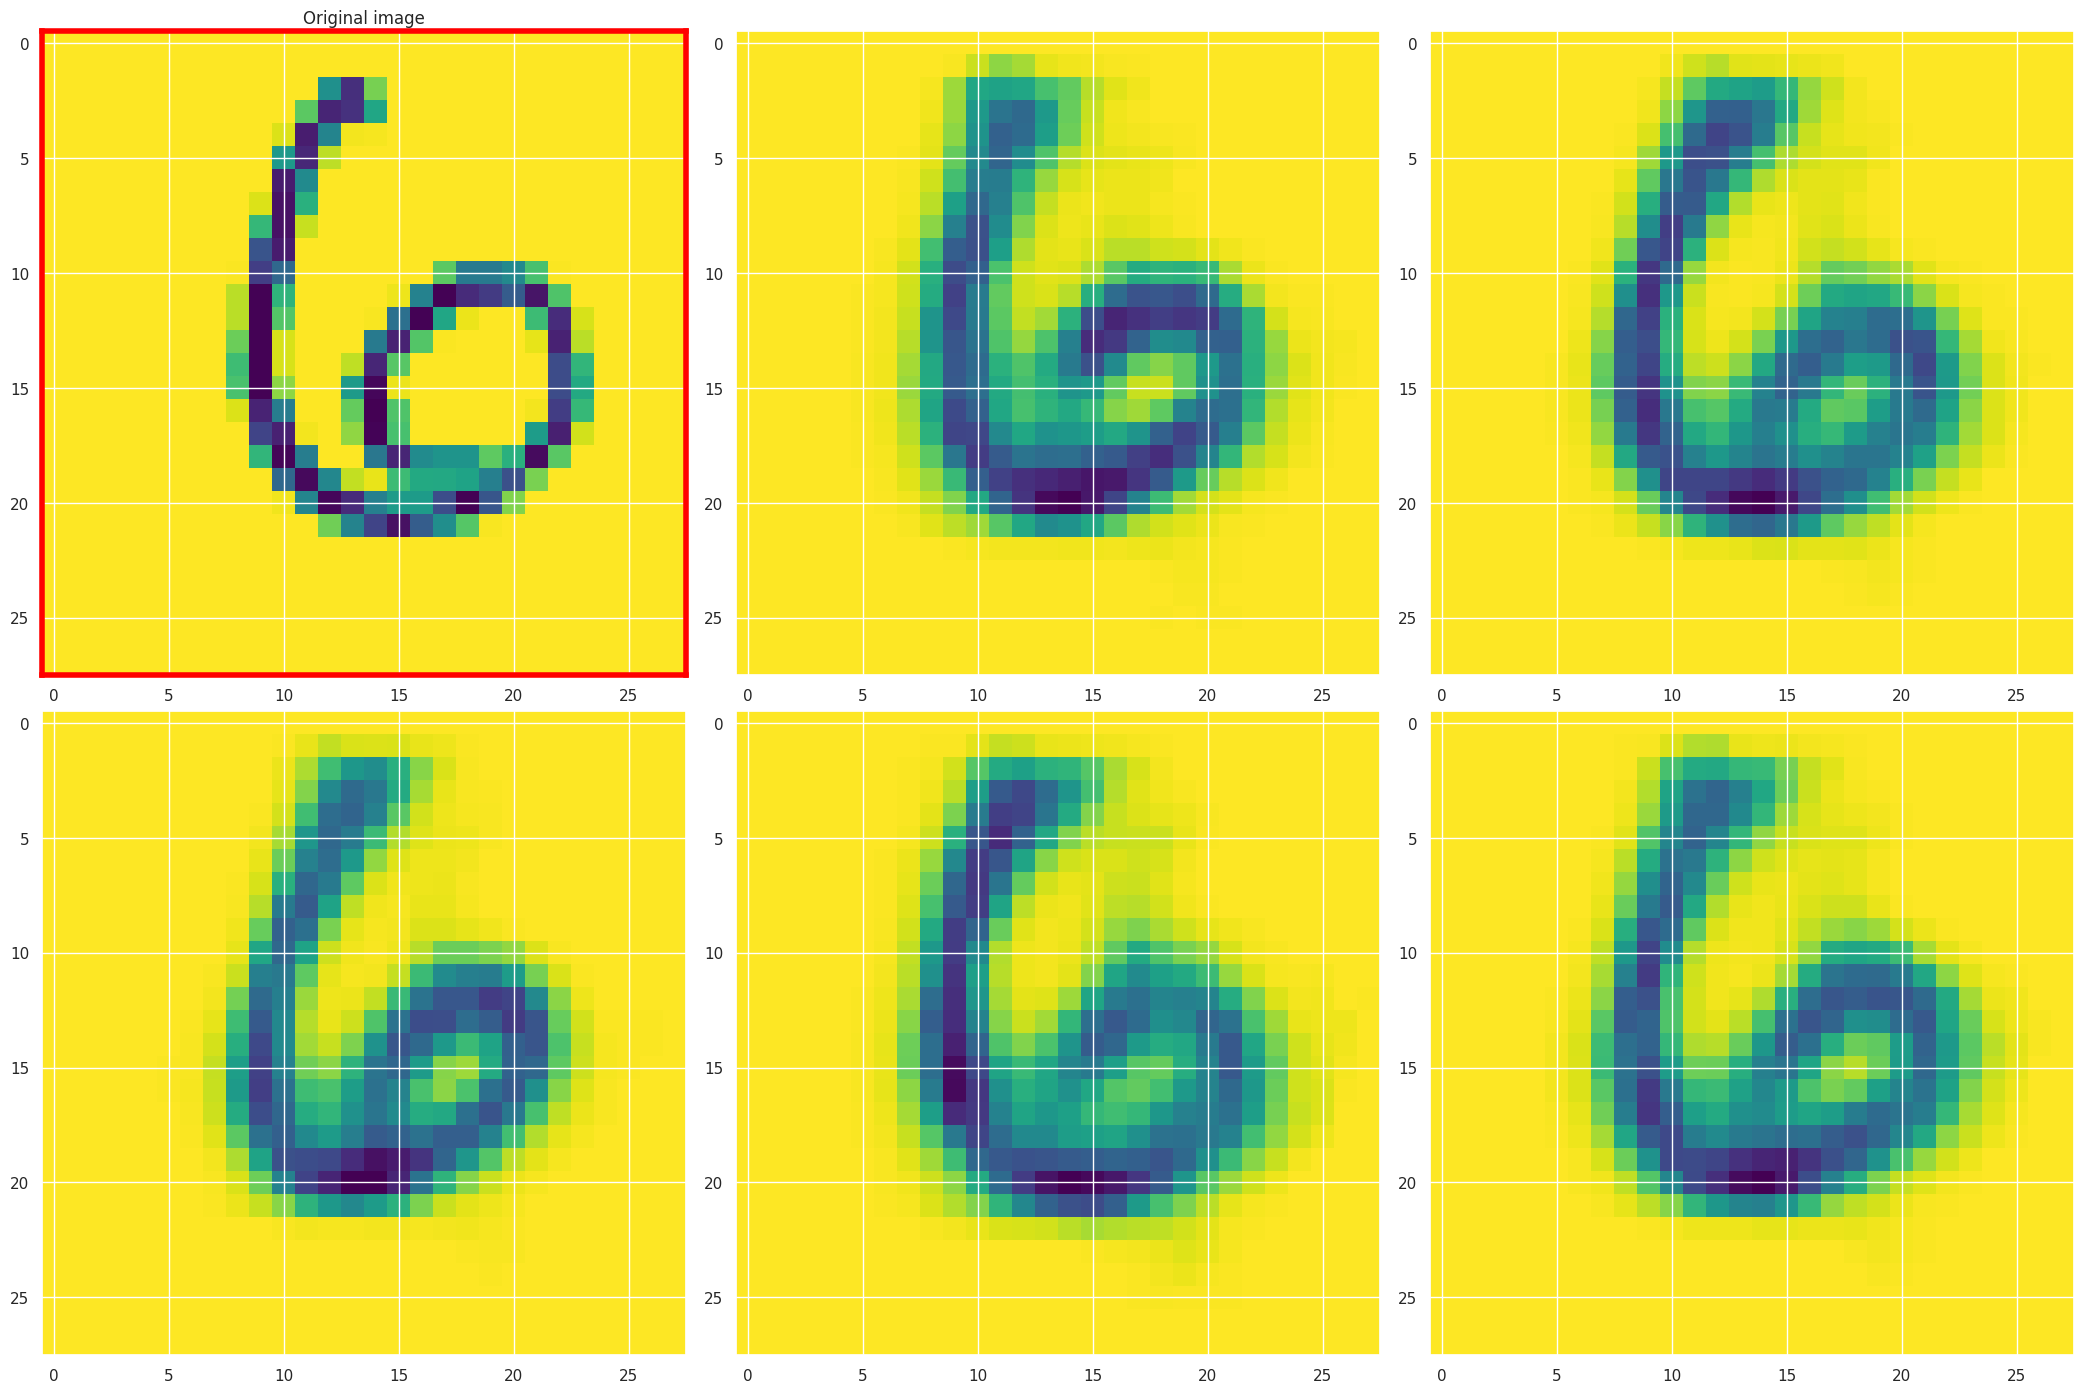

In [85]:
n=100
visualize(xtest[n],VAE_MSE)

In [86]:
generate(VAE,8,"cross_entropy.png")
generate(VAE_MSE,8,"MSE.png")